# Modelos ARIMA



In [229]:
import os
# os.environ["SM_FRAMEWORK"] = "tf.keras"
import pathlib
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# import seaborn as sns
import datetime as dt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Flatten, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
# from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore")

In [230]:
#Conexión de google drive con el repo
# from google.colab import drive
# drive.mount('/content/drive')

##==========================
# ruta = os.path.join("/content/drive/MyDrive","MonografiaUdeA")
# os.chdir(ruta)
abspath = pathlib.Path.cwd()
print(f"Directorio de trabajo: {abspath}")
###==========================

Directorio de trabajo: d:\OneDrive\OneDrive - INTERCONEXION ELECTRICA S.A. E.S.P\Posgrado\EspecializacionAnalitica\Sem_2\06_monografia\MonografiaUdeA


In [231]:
modelo_implementar = ['SARIMAX']

def parse(x):
    return dt.datetime.strptime(x, '%Y-%m-%d')
dataset = pd.read_csv(os.path.join(abspath,"datasets", "procesado", "3_dataset_filtrado.csv"), index_col=0, date_parser=parse)
df = dataset.copy()#.iloc[:,[0]].reset_index()
df = df[['precio_bolsa']].reset_index()

In [232]:
df['fecha'] = pd.to_datetime(df['fecha'])
df.set_index('fecha', inplace=True)
df.head()

,precio_bolsa
fecha,
2010-01-01,120.501228
2010-01-02,118.495340
2010-01-03,121.160145
2010-01-04,123.962937
2010-01-05,120.666437


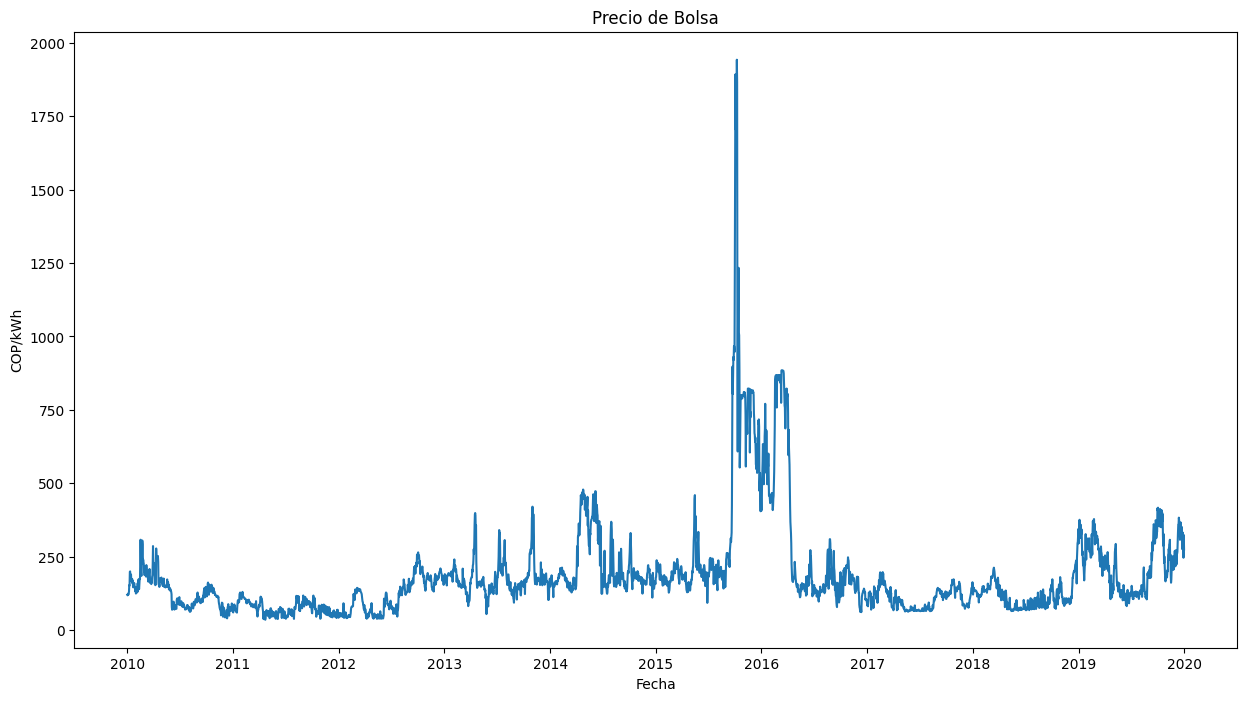

In [233]:
# Plot the time series
plt.figure(figsize = (15,8))
plt.plot(df['precio_bolsa'])
plt.title('Precio de Bolsa')
plt.xlabel('Fecha')
plt.ylabel('COP/kWh')
plt.show()

## Validación de estacionariedad

In [234]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['precio_bolsa'])
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -4.436130
p-value: 0.000256


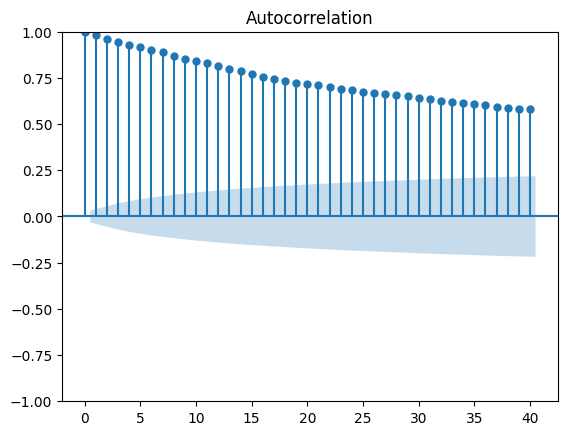

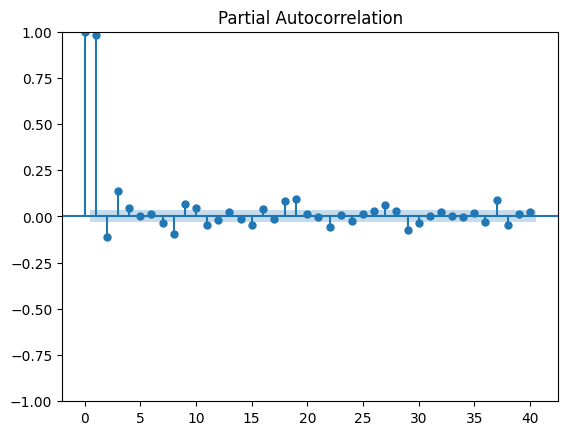

In [235]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['precio_bolsa'], lags=40)
plot_pacf(df['precio_bolsa'], lags=40)
plt.show()

Un valor p inferior a 0,05 indica estacionariedad y nuestros datos cumplen con este criterio, por lo que no es necesario realizar diferenciación.

In [236]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

                                     SARIMAX Results                                      
Dep. Variable:                       precio_bolsa   No. Observations:                 2921
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -14335.778
Date:                            Tue, 18 Jun 2024   AIC                          28681.557
Time:                                    03:40:37   BIC                          28711.409
Sample:                                01-01-2010   HQIC                         28692.314
                                     - 12-30-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2893      0.021    -13.574      0.000      -0.331      -0.248
ma.L1          0.4473      0.021   

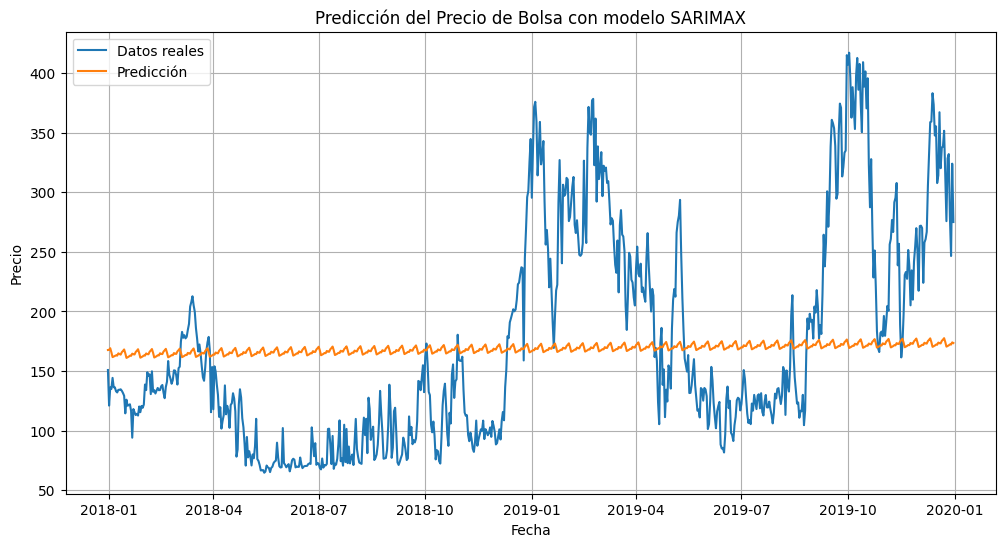

mse 20253.36
mae 135.46
rmse 142.314
mape 42.691


In [240]:
from sklearn.metrics import mean_squared_error

def sarimax_model (df, train_porc = 0.8):
    train_size = int(len(df) * train_porc)
    train, test = df[0:train_size], df[train_size:]
    order = (1, 1, 1) 
    seasonal_order = (1, 1, 1, 12)

    model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()

    print(results.summary())

    forecast = results.get_forecast(steps=len(test))
    predicted_price = forecast.predicted_mean.values

    # print(f'Predicción del precio_bolsa para el siguiente período: {predicted_price}')

    # Graficar los resultados
    plt.figure(figsize=(12, 6))
    # plt.plot(train.index, train, label='Datos de entrenamiento')
    plt.plot(test.index, test, label='Datos reales')
    plt.plot(test.index, predicted_price, label='Predicción')
    plt.title('Predicción del Precio de Bolsa con modelo SARIMAX')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.legend()
    plt.grid(True)
    plt.show()

    element_to_predict = 31
    mse = mean_squared_error(test[-int(element_to_predict):], predicted_price[-int(element_to_predict):])
    mae = mean_absolute_error(test[-int(element_to_predict):], predicted_price[-int(element_to_predict):])
    rmse = mean_squared_error(test[-int(element_to_predict):], predicted_price[-int(element_to_predict):], squared=False)
    mape = mean_absolute_percentage_error(test[-int(element_to_predict):], predicted_price[-int(element_to_predict):].reshape(element_to_predict,1))
    print("mse", mse.round(3))
    print("mae", mae.round(3))
    print("rmse", rmse.round(3))
    print("mape", mape.round(3))

    return predicted_price


fitted_series = sarimax_model(df, 0.8)

In [238]:
# !pip install pydataxm
# import pydataxm
# from pydataxm.pydataxm import ReadDB
# consult = ReadDB()